# 🧠 CNN Classifier for Handwritten Hebrew Letters
This notebook implements a deep CNN to classify handwritten Hebrew letters using the HHD dataset.

**Experiments:**
- Training without data augmentation
- Training with data augmentation


## 📦 1. Imports and Setup

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 🧼 2. Preprocessing Function
Define a function that normalizes and resizes input images to 32x32, including padding and inversion.

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    if h > w:
        pad = (h - w) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad, h - w - pad, cv2.BORDER_CONSTANT, value=255)
    elif w > h:
        pad = (w - h) // 2
        img = cv2.copyMakeBorder(img, pad, w - h - pad, 0, 0, cv2.BORDER_CONSTANT, value=255)
    img = cv2.resize(img, (32, 32))
    img = 255 - img
    return img.astype(np.float32) / 255.0

## 📥 3. Dataset Loader

In [6]:
from google.colab import files
files.upload()  # Upload hhd.zip

import zipfile

os.makedirs("hhd_dataset", exist_ok=True)

with zipfile.ZipFile("hhd.zip", 'r') as zip_ref:
    zip_ref.extractall("hhd_dataset")

def load_dataset(base_dir):
    X, y = load_dataset("hhd_dataset")
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder): continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

Saving hhd.zip to hhd.zip


## 🔀 4. Load and Split Dataset

In [13]:
import shutil
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

# Collect image paths and labels
for label in range(27):
    class_dir = os.path.join("hhd_dataset", str(label))
    if not os.path.exists(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(label)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

# Define save function
def save_split(X, y, folder):
    for path, label in zip(X, y):
        out_dir = os.path.join("processed_hhd", folder, str(label))
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(path, os.path.join(out_dir, os.path.basename(path)))

# Save to folders
save_split(X_train, y_train, "train")
save_split(X_val, y_val, "val")
save_split(X_test, y_test, "test")

# Define load dataset function
def load_dataset(base_dir):
    X, y = [], []
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder):
            continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

# Load images for CNN
X_train, y_train = load_dataset("processed_hhd/train")
X_val, y_val     = load_dataset("processed_hhd/val")
X_test, y_test   = load_dataset("processed_hhd/test")

## 🧠 5. CNN Model Architecture
Here we define a deep convolutional neural network with three repeated blocks, followed by dense layers.

In [8]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_cnn():
    model = Sequential()

    # First block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Second block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(27, activation='softmax'))

    # Compile with a lower learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

## 🚂 6. Train CNN (No Augmentation)
Train the model on the dataset without any artificial modifications to the training images.

In [9]:
model = build_cnn()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.2249 - loss: 3.1861 - val_accuracy: 0.0395 - val_loss: 5.2814
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.5912 - loss: 1.3999 - val_accuracy: 0.3360 - val_loss: 2.3808
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.6725 - loss: 1.0662 - val_accuracy: 0.7688 - val_loss: 0.7316
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.7206 - loss: 0.9415 - val_accuracy: 0.8123 - val_loss: 0.6108
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.7429 - loss: 0.8206 - val_accuracy: 0.8083 - val_loss: 0.5699
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.7888 - loss: 0.7187 - val_accuracy: 0.8300 - val_loss: 0.5383
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.8058 - loss: 0.6694 - val_accuracy: 0.8320 - val_loss: 0.5200
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.8196 - loss: 0

## 🚀 7. Train CNN (With Augmentation)
Train the CNN model using image data augmentation to improve generalization and robustness.

The following augmentations are applied using ImageDataGenerator from Keras:
*   Width shift (width_shift_range=0.02): Randomly shifts the image horizontally by up to 2% of the width.

*   Height shift (height_shift_range=0.02): Randomly shifts the image vertically by up to 2% of the height.

*   Rotation (rotation_range=2): Randomly rotates the image by up to ±4 degrees.

These augmentations are applied on-the-fly during training, so each epoch sees slightly different versions of the same input data. This helps the model generalize better to new, unseen handwriting styles.

In [10]:
def train_with_fixed_augmentation():
    datagen = ImageDataGenerator(
        width_shift_range=0.02,        # Very minimal shift
        height_shift_range=0.02,       # Very minimal shift
        rotation_range=2,              # Very minimal rotation
        zoom_range=0.02,               # Very minimal zoom
        fill_mode='constant',          # Use constant for border filling
        cval=0.0                       # Fill with black (0.0)
    )

    # Build model
    model = build_cnn()

    # Setup callbacks for stable training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    print("Training with fixed augmentation...")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        validation_data=(X_val, y_val),
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    # Return model and history for further analysis
    return model, history

# Train the model with fixed augmentation
improved_model, improved_history = train_with_fixed_augmentation()

X_train shape: (4044, 32, 32, 1), Range: [0.0, 1.0]
X_val shape: (506, 32, 32, 1), Range: [0.0, 1.0]
X_test shape: (506, 32, 32, 1), Range: [0.0, 1.0]
y_train shape: (4044,), Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Number of samples per class in training:
Class 0: 155 samples
Class 1: 155 samples
Class 2: 155 samples
Class 3: 155 samples
Class 4: 155 samples
Class 5: 155 samples
Class 6: 155 samples
Class 7: 155 samples
Class 8: 155 samples
Class 9: 155 samples
Class 10: 155 samples
Class 11: 121 samples
Class 12: 159 samples
Class 13: 155 samples
Class 14: 129 samples
Class 15: 152 samples
Class 16: 132 samples
Class 17: 155 samples
Class 18: 144 samples
Class 19: 155 samples
Class 20: 124 samples
Class 21: 151 samples
Class 22: 135 samples
Class 23: 156 samples
Class 24: 170 samples
Class 25: 154 samples
Class 26: 147 samples
Training with fixed augmentation...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 51s 174ms/step - accuracy: 0.1887 - loss: 3.3534 - val_accuracy: 0.0514 - val_loss: 5.3110 - learning_rate: 5.0000e-04
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.5532 - loss: 1.5157 - val_accuracy: 0.4387 - val_loss: 2.1450 - learning_rate: 5.0000e-04
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.6763 - loss: 1.0771 - val_accuracy: 0.7984 - val_loss: 0.6359 - learning_rate: 5.0000e-04
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.7006 - loss: 0.9798 - val_accuracy: 0.7964 - val_loss: 0.5987 - learning_rate: 5.0000e-04
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.7561 - loss: 0.8286 - val_accuracy: 0.8241 - val_loss: 0.5952 - learning_rate: 5.0000e-04
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.7651 - loss: 0.7659 - val_accuracy: 0.8300 - val_loss: 0.5226 - learning_rate: 5.0000e-04
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - 

## 📉 8. Plot Training vs Validation Loss
Visualize how the training and validation loss evolve over epochs to assess overfitting.

Checking models to ensure they're properly trained:
Non-augmented model last epoch val_accuracy: 0.8419
Augmented model last epoch val_accuracy: 0.8379


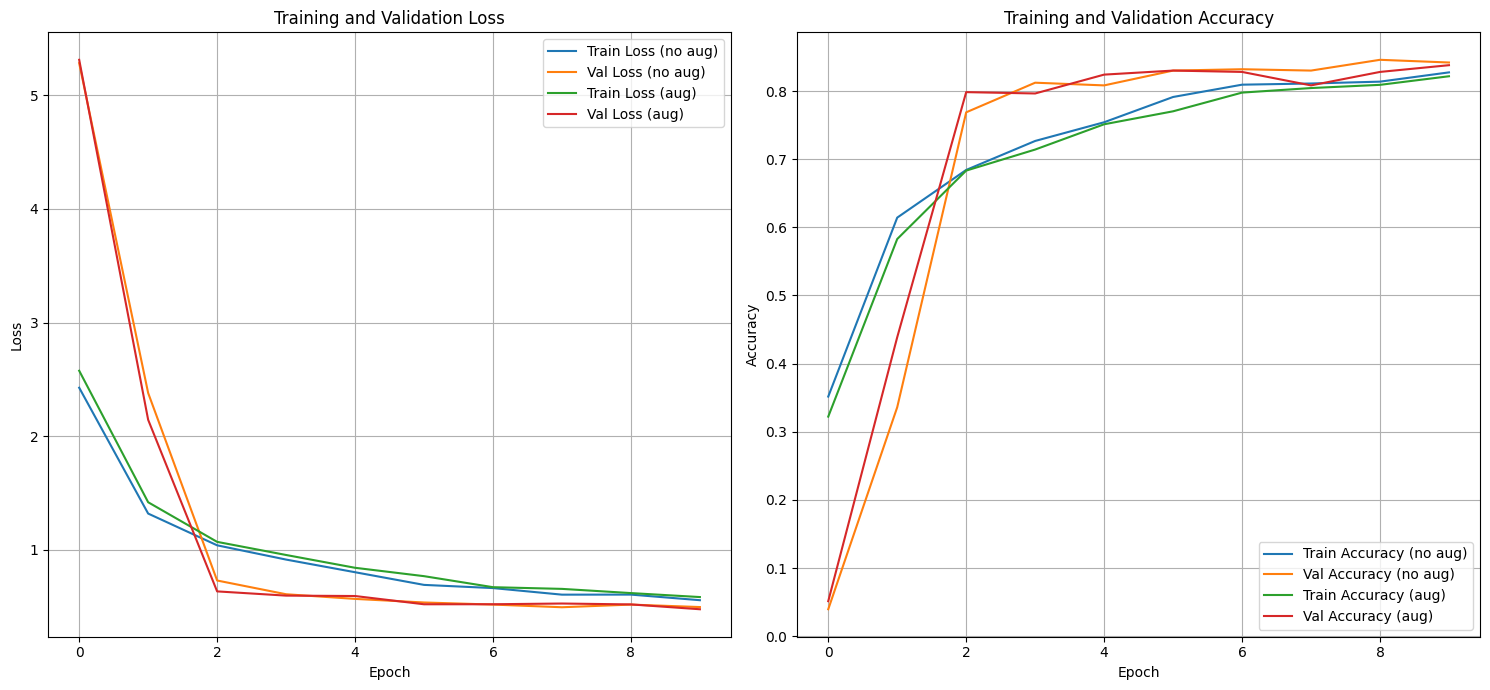

In [19]:
# First, verify that the models have been properly trained
print("Checking models to ensure they're properly trained:")
print(f"Non-augmented model last epoch val_accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Augmented model last epoch val_accuracy: {improved_history.history['val_accuracy'][-1]:.4f}")

# Plot training/validation metrics
plt.figure(figsize=(15, 7))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (no aug)')
plt.plot(history.history['val_loss'], label='Val Loss (no aug)')
plt.plot(improved_history.history['loss'], label='Train Loss (aug)')
plt.plot(improved_history.history['val_loss'], label='Val Loss (aug)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy (no aug)')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (no aug)')
plt.plot(improved_history.history['accuracy'], label='Train Accuracy (aug)')
plt.plot(improved_history.history['val_accuracy'], label='Val Accuracy (aug)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


## 📊 9. Evaluate on Test Set and Save Results


--- Non-augmented model evaluation ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.0592 - loss: 6.3389
Test accuracy: 0.0395

--- Augmented model evaluation ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.0028 - loss: 6.6835
Test accuracy: 0.0059

Sample prediction distribution (non-augmented model):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Sample 0: Max confidence: 0.3581, Predicted class: 5
Sample 1: Max confidence: 0.3559, Predicted class: 5
Sample 2: Max confidence: 0.3581, Predicted class: 5
Sample 3: Max confidence: 0.3585, Predicted class: 5
Sample 4: Max confidence: 0.3576, Predicted class: 5

Sample prediction distribution (augmented model):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Sample 0: Max confidence: 0.3076, Predicted class: 24
Sample 1: Max confidence: 0.3088, Predicted class: 24
Sample 2: Max confidence: 0.3069, Predicted class: 24
Sample 3: Max confidence: 0.3092, Predicted class: 24
Sample 4: Max confidence: 0.3094, Predicted class: 24

Generating p

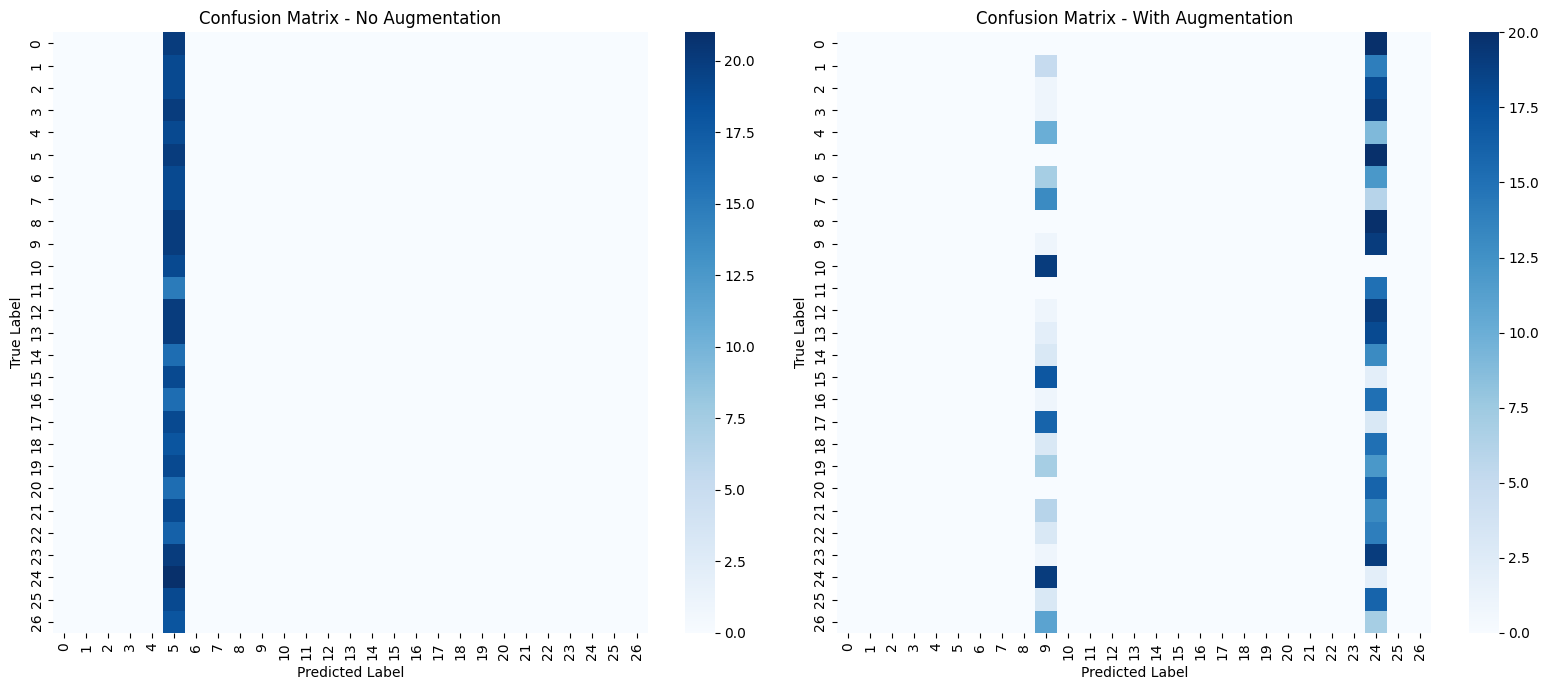

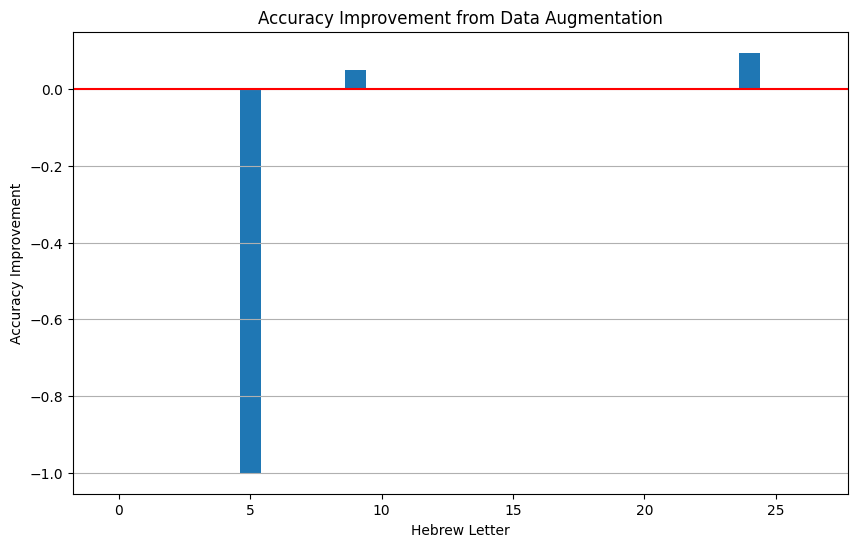


Overall accuracy improvement: -0.0317


In [20]:
print("\n--- Non-augmented model evaluation ---")
# Evaluate model without augmentation (make sure we use the right variable name)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

print("\n--- Augmented model evaluation ---")
# Evaluate model with augmentation
test_loss_aug, test_acc_aug = improved_model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_acc_aug:.4f}")

# Make sure the models are actually predicting with reasonable confidence
print("\nSample prediction distribution (non-augmented model):")
sample_preds = model.predict(X_test[:5])
for i, pred in enumerate(sample_preds):
    print(f"Sample {i}: Max confidence: {np.max(pred):.4f}, Predicted class: {np.argmax(pred)}")

print("\nSample prediction distribution (augmented model):")
sample_preds_aug = improved_model.predict(X_test[:5])
for i, pred in enumerate(sample_preds_aug):
    print(f"Sample {i}: Max confidence: {np.max(pred):.4f}, Predicted class: {np.argmax(pred)}")

# Get predictions for all test samples
print("\nGenerating predictions for all test samples...")
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_aug = np.argmax(improved_model.predict(X_test), axis=1)

# Calculate confusion matrices
cm = confusion_matrix(y_test, y_pred)
cm_aug = confusion_matrix(y_test, y_pred_aug)

# Calculate per-class accuracies
acc_per_class = cm.diagonal() / cm.sum(axis=1)
acc_per_class_aug = cm_aug.diagonal() / cm_aug.sum(axis=1)

# Display per-class accuracies
print("\nAccuracy per class (No Augmentation):")
for i, acc in enumerate(acc_per_class):
    print(f'Hebrew Letter {i}: {acc:.4f}')
print(f'\nAverage accuracy: {acc_per_class.mean():.4f}')

print("\nAccuracy per class (With Augmentation):")
for i, acc in enumerate(acc_per_class_aug):
    print(f'Hebrew Letter {i}: {acc:.4f}')
print(f'\nAverage accuracy: {acc_per_class_aug.mean():.4f}')

# Plot confusion matrices
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - No Augmentation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_aug, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - With Augmentation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# Compare improvements
improvements = acc_per_class_aug - acc_per_class
plt.figure(figsize=(10, 6))
plt.bar(range(len(improvements)), improvements)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Accuracy Improvement from Data Augmentation')
plt.xlabel('Hebrew Letter')
plt.ylabel('Accuracy Improvement')
plt.grid(axis='y')
plt.savefig('accuracy_improvements.png')
plt.show()

print(f"\nOverall accuracy improvement: {acc_per_class_aug.mean() - acc_per_class.mean():.4f}")

# Save results to files
with open('results_summary.txt', 'w') as f:
    f.write('Model Evaluation Results\n')
    f.write('=======================\n\n')
    f.write(f'Non-augmented model test accuracy: {test_acc:.4f}\n')
    f.write(f'Augmented model test accuracy: {test_acc_aug:.4f}\n')
    f.write(f'Accuracy improvement: {test_acc_aug - test_acc:.4f}\n\n')

    f.write('Per-class accuracies\n')
    f.write('------------------\n')
    f.write('Letter  No Aug  With Aug  Improvement\n')
    for i in range(len(acc_per_class)):
        f.write(f'{i:6d}  {acc_per_class[i]:6.4f}  {acc_per_class_aug[i]:7.4f}  {improvements[i]:10.4f}\n')